In [379]:
import numpy as np
import trimesh
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt


In [380]:
mesh = trimesh.load_mesh('Object/Deposition Head.stl')

In [381]:
points = 1000 
scale_voxel = 0.5
Dim_Latent_value = 16

In [382]:
mesh.apply_translation(-mesh.bounds[0])

<trimesh.Trimesh(vertices.shape=(725, 3), faces.shape=(1446, 3))>

In [383]:
random_points = np.random.uniform(mesh.bounds[0], mesh.bounds[1] , (points , 3) )

In [384]:
sdf = trimesh.proximity.signed_distance(mesh, random_points)
sdf.shape

(1000,)

In [385]:
voxel_shape =np.append((np.round(mesh.bounds[1])/scale_voxel).astype(int), Dim_Latent_value )

In [386]:
random_points  = np.divide(random_points,scale_voxel)
random_points_voxel = np.floor(random_points).astype(int)
delta = random_points - random_points_voxel

In [387]:
ind = int(points*0.8)

train_Ti = torch.from_numpy(delta[:ind]).float()
train_sdf = torch.tensor(sdf[:ind]).float()

test_Ti = torch.from_numpy(delta[ind-1:]).float()
test_sdf= torch.tensor(sdf[ind-1:]).float()


In [388]:
class DeepLS(nn.Module):
    
    def __init__(self, Dim_intern , Dim_atent , voxel_shape, device='cpu'):
        super(DeepLS,self).__init__()
        
        self.block= nn.Sequential( nn.Linear(3 + Dim_atent,Dim_intern), nn.ReLU(),
                                   nn.Linear(Dim_intern,Dim_intern), nn.ReLU(),
                                   nn.Linear(Dim_intern,Dim_intern),nn.ReLU() ,
                                     nn.Linear(Dim_intern,Dim_intern),nn.ReLU(),
                                    nn.Linear(Dim_intern,1))
        
        self.latente= torch.randn(tuple(voxel_shape),device=device, requires_grad=True)
        
    def forward(self,latente_value , coord ):
        X = torch.cat((latente_value, coord ) , dim = -1).float() #ou double()
        
        return  self.block(X)

In [389]:
def train(model, optimizer, scheduler, train_Ti ,random_points_voxel ,train_sdf, nb_epochs, nb_bins=nb_bins, device ='cpu'):
    
    criterion = nn.MSELoss()

    training_loss = []
    for epoch in tqdm(range(nb_epochs)):
        Outputs = []
        for ind, batch in enumerate(train_Ti):
        
            coords = batch.to(device)
            latent_values = model.latente[random_points_voxel[ind,0],random_points_voxel[ind,1],random_points_voxel[ind,2]].to(device)


            Outputs.append(model(latent_values, coords))
        Outputs= torch.stack(Outputs)  
        target_values = train_sdf.to(device)   
        # Calculer la perte
        loss = ((Outputs - target_values)**2).mean()

        # Mettre à jour les poids du modèle
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stocker la perte pour ce batch
        training_loss.append(loss.item())
                   
        scheduler.step()
    

    return training_loss



In [390]:
# Hyperparameters
nb_epochs = 75
lr = 1e-3
gamma = 0.5
nb_bins = 192
gamma = 0.5

model = DeepLS(64 ,Dim_Latent_value ,voxel_shape)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7], gamma=gamma)


loos = train(model, optimizer, scheduler, train_Ti ,random_points_voxel ,train_sdf, nb_epochs, nb_bins=nb_bins)

100%|███████████████████████████████████████████| 75/75 [30:32<00:00, 24.43s/it]


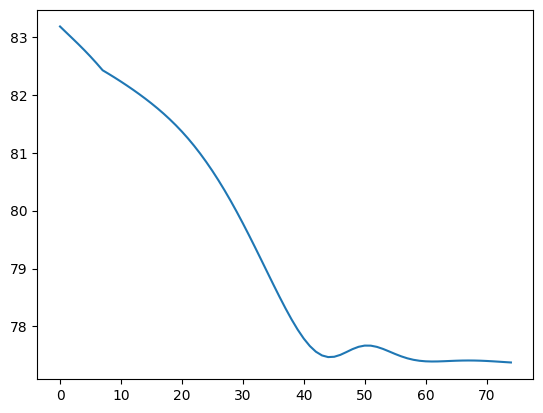

In [391]:
plt.plot(loos)

In [361]:
loos = train(model, optimizer, scheduler, test_Ti ,random_points_voxel ,test_sdf, nb_epochs, nb_bins=nb_bins)

100%|████████████████████████████████████████| 200/200 [00:01<00:00, 101.30it/s]


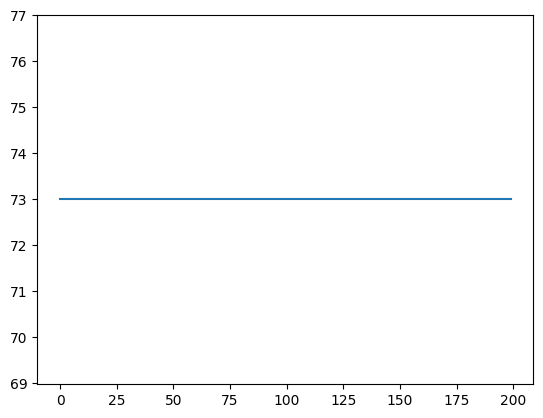

In [363]:
plt.plot(loos)

In [ ]:
latent_values = model.latente[random_points_voxel[ind,0],random_points_voxel[ind,1],random_points_voxel[ind,2]].to(device)